# TP04 - Projeto de Bloco


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

## 1. Download e Carregamento do Dataset

In [14]:
import kagglehub

path = kagglehub.dataset_download("maharshipandya/-spotify-tracks-dataset")
print("Path to dataset files:", path)

Path to dataset files: /Users/gtauber/.cache/kagglehub/datasets/maharshipandya/-spotify-tracks-dataset/versions/1


In [15]:
import os
csv_file = os.path.join(path, 'dataset.csv')
df = pd.read_csv(csv_file)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
df.head()

Dataset shape: (114000, 21)
Columns: ['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre']


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


## 2. Preparação dos Dados

In [16]:
numeric_features = ['danceability', 'energy', 'loudness', 'speechiness',
                   'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

df['popular'] = (df['popularity'] > df['popularity'].median()).astype(int)

X = df[numeric_features].dropna()
y = df.loc[X.index, 'popular']

print(f"Features shape: {X.shape}")
print(f"Class distribution: {y.value_counts().to_dict()}")

Features shape: (114000, 9)
Class distribution: {0: 58451, 1: 55549}


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")

Train set: (91200, 9)
Test set: (22800, 9)


## 3. Clusterização K-Médias

### 3.1 Método do Cotovelo

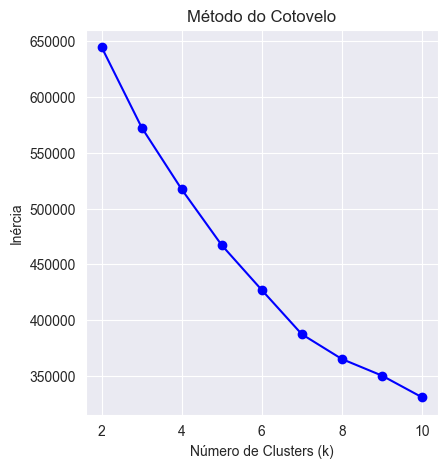

In [18]:
inertias = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo')
plt.grid(True)

### 3.2 Índice de Silhueta

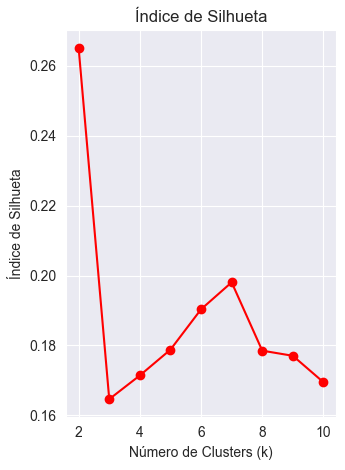

K ótimo baseado na silhueta: 2
Silhueta máxima: 0.265


In [19]:
# Índice de Silhueta
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_train_scaled)
    silhouette_avg = silhouette_score(X_train_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'ro-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Índice de Silhueta')
plt.title('Índice de Silhueta')
plt.grid(True)
plt.tight_layout()
plt.show()

optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"K ótimo baseado na silhueta: {optimal_k}")
print(f"Silhueta máxima: {max(silhouette_scores):.3f}")

## 4. Criação de Features de Distância aos Clusters

In [20]:
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_final.fit(X_train_scaled)

def calculate_cluster_distances(X, kmeans_model):
    distances = []
    centroids = kmeans_model.cluster_centers_
    
    for sample in X:
        sample_distances = []
        for centroid in centroids:
            dist = np.linalg.norm(sample - centroid)
            sample_distances.append(dist)
        distances.append(sample_distances)
    
    return np.array(distances)

train_distances = calculate_cluster_distances(X_train_scaled, kmeans_final)
test_distances = calculate_cluster_distances(X_test_scaled, kmeans_final)

X_train_with_clusters = np.hstack([X_train_scaled, train_distances])
X_test_with_clusters = np.hstack([X_test_scaled, test_distances])

print(f"Shape sem clusters: {X_train_scaled.shape}")
print(f"Shape com clusters: {X_train_with_clusters.shape}")

Shape sem clusters: (91200, 9)
Shape com clusters: (91200, 11)


## 5. Treinamento de Modelos

### 5.1 Modelos SVM

In [21]:
from sklearn.model_selection import StratifiedShuffleSplit

# Usar amostra menor para GridSearch (30% dos dados)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.7, random_state=42)
for train_idx, _ in sss.split(X_train_scaled, y_train):
    X_train_sample = X_train_scaled[train_idx]
    y_train_sample = y_train.iloc[train_idx]

svm_params = {
    'linear': {'C': [1]},
    'poly': {'C': [1], 'degree': [3]},
    'rbf': {'C': [1], 'gamma': ['scale']}
}

results = {}

print("Treinando SVM sem features de cluster (versão otimizada)...")
for kernel_name in ['linear', 'poly', 'rbf']:
    if kernel_name == 'linear':
        svm = SVC(kernel='linear', C=1, probability=True, random_state=42, max_iter=1000)
    elif kernel_name == 'poly':
        svm = SVC(kernel='poly', C=1, degree=3, probability=True, random_state=42, max_iter=1000)
    else:  # rbf
        svm = SVC(kernel='rbf', C=1, gamma='scale', probability=True, random_state=42, max_iter=1000)
    
    svm.fit(X_train_sample, y_train_sample)
    
    y_pred = svm.predict(X_test_scaled)
    y_proba = svm.predict_proba(X_test_scaled)[:, 1]
    
    results[f'SVM_{kernel_name}_sem_cluster'] = {
        'model': svm,
        'best_params': {'kernel': kernel_name},
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, y_proba),
        'y_pred': y_pred,
        'y_proba': y_proba
    }
    print(f"  {kernel_name}: Accuracy = {results[f'SVM_{kernel_name}_sem_cluster']['accuracy']:.3f}")

Treinando SVM sem features de cluster (versão otimizada)...
  linear: Accuracy = 0.510
  poly: Accuracy = 0.496
  rbf: Accuracy = 0.560


In [22]:
print("\nTreinando SVM com features de cluster (versão otimizada)...")

X_train_with_clusters_sample = X_train_with_clusters[train_idx]

for kernel_name in ['linear', 'poly', 'rbf']:
    if kernel_name == 'linear':
        svm = SVC(kernel='linear', C=1, probability=True, random_state=42, max_iter=1000)
    elif kernel_name == 'poly':
        svm = SVC(kernel='poly', C=1, degree=3, probability=True, random_state=42, max_iter=1000)
    else:  # rbf
        svm = SVC(kernel='rbf', C=1, gamma='scale', probability=True, random_state=42, max_iter=1000)
    
    svm.fit(X_train_with_clusters_sample, y_train_sample)
    
    y_pred = svm.predict(X_test_with_clusters)
    y_proba = svm.predict_proba(X_test_with_clusters)[:, 1]
    
    results[f'SVM_{kernel_name}_com_cluster'] = {
        'model': svm,
        'best_params': {'kernel': kernel_name},
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, y_proba),
        'y_pred': y_pred,
        'y_proba': y_proba
    }
    print(f"  {kernel_name}: Accuracy = {results[f'SVM_{kernel_name}_com_cluster']['accuracy']:.3f}")


Treinando SVM com features de cluster (versão otimizada)...
  linear: Accuracy = 0.512
  poly: Accuracy = 0.491
  rbf: Accuracy = 0.525


### 5.2 Modelos Random Forest

In [23]:
# Configuração do Random Forest - OTIMIZADA
rf_params = {
    'n_estimators': 100,  # Fixo em 100
    'max_depth': 10,  # Fixo em 10
    'min_samples_split': 5,
    'min_samples_leaf': 2
}

# Treinar Random Forest sem features de cluster
print("Treinando Random Forest sem features de cluster (versão otimizada)...")
rf = RandomForestClassifier(**rf_params, random_state=42, n_jobs=-1)
rf.fit(X_train_sample, y_train_sample)

y_pred = rf.predict(X_test_scaled)
y_proba = rf.predict_proba(X_test_scaled)[:, 1]

results['RF_sem_cluster'] = {
    'model': rf,
    'best_params': rf_params,
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1': f1_score(y_test, y_pred),
    'auc': roc_auc_score(y_test, y_proba),
    'y_pred': y_pred,
    'y_proba': y_proba
}
print(f"  Accuracy = {results['RF_sem_cluster']['accuracy']:.3f}")

Treinando Random Forest sem features de cluster (versão otimizada)...
  Accuracy = 0.641


In [24]:
# Treinar Random Forest com features de cluster
print("\nTreinando Random Forest com features de cluster (versão otimizada)...")
rf = RandomForestClassifier(**rf_params, random_state=42, n_jobs=-1)
rf.fit(X_train_with_clusters_sample, y_train_sample)

y_pred = rf.predict(X_test_with_clusters)
y_proba = rf.predict_proba(X_test_with_clusters)[:, 1]

results['RF_com_cluster'] = {
    'model': rf,
    'best_params': rf_params,
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1': f1_score(y_test, y_pred),
    'auc': roc_auc_score(y_test, y_proba),
    'y_pred': y_pred,
    'y_proba': y_proba
}
print(f"  Accuracy = {results['RF_com_cluster']['accuracy']:.3f}")


Treinando Random Forest com features de cluster (versão otimizada)...
  Accuracy = 0.645


## 6. Avaliação de Modelos

In [25]:
metrics_df = pd.DataFrame()

for model_name, model_results in results.items():
    metrics_df = pd.concat([metrics_df, pd.DataFrame({
        'Modelo': [model_name],
        'Accuracy': [model_results['accuracy']],
        'Precision': [model_results['precision']],
        'Recall': [model_results['recall']],
        'F1-Score': [model_results['f1']],
        'AUC-ROC': [model_results['auc']]
    })], ignore_index=True)

# Ordenar por accuracy
metrics_df = metrics_df.sort_values('Accuracy', ascending=False)
print("\nTabela Comparativa de Métricas:")
print(metrics_df.to_string(index=False))


Tabela Comparativa de Métricas:
                Modelo  Accuracy  Precision   Recall  F1-Score  AUC-ROC
        RF_com_cluster  0.644825   0.633322 0.643924  0.638579 0.703362
        RF_sem_cluster  0.640570   0.627840 0.644284  0.635956 0.697332
   SVM_rbf_sem_cluster  0.559868   0.555384 0.485149  0.517896 0.418197
   SVM_rbf_com_cluster  0.525307   0.510808 0.610441  0.556198 0.471457
SVM_linear_com_cluster  0.511623   0.499406 0.946355  0.653795 0.471708
SVM_linear_sem_cluster  0.509518   0.497752 0.727543  0.591100 0.491788
  SVM_poly_sem_cluster  0.495702   0.491336 0.990279  0.656797 0.438184
  SVM_poly_com_cluster  0.490702   0.488951 0.999820  0.656734 0.416060


## 7. Análise Comparativa - Visualizações

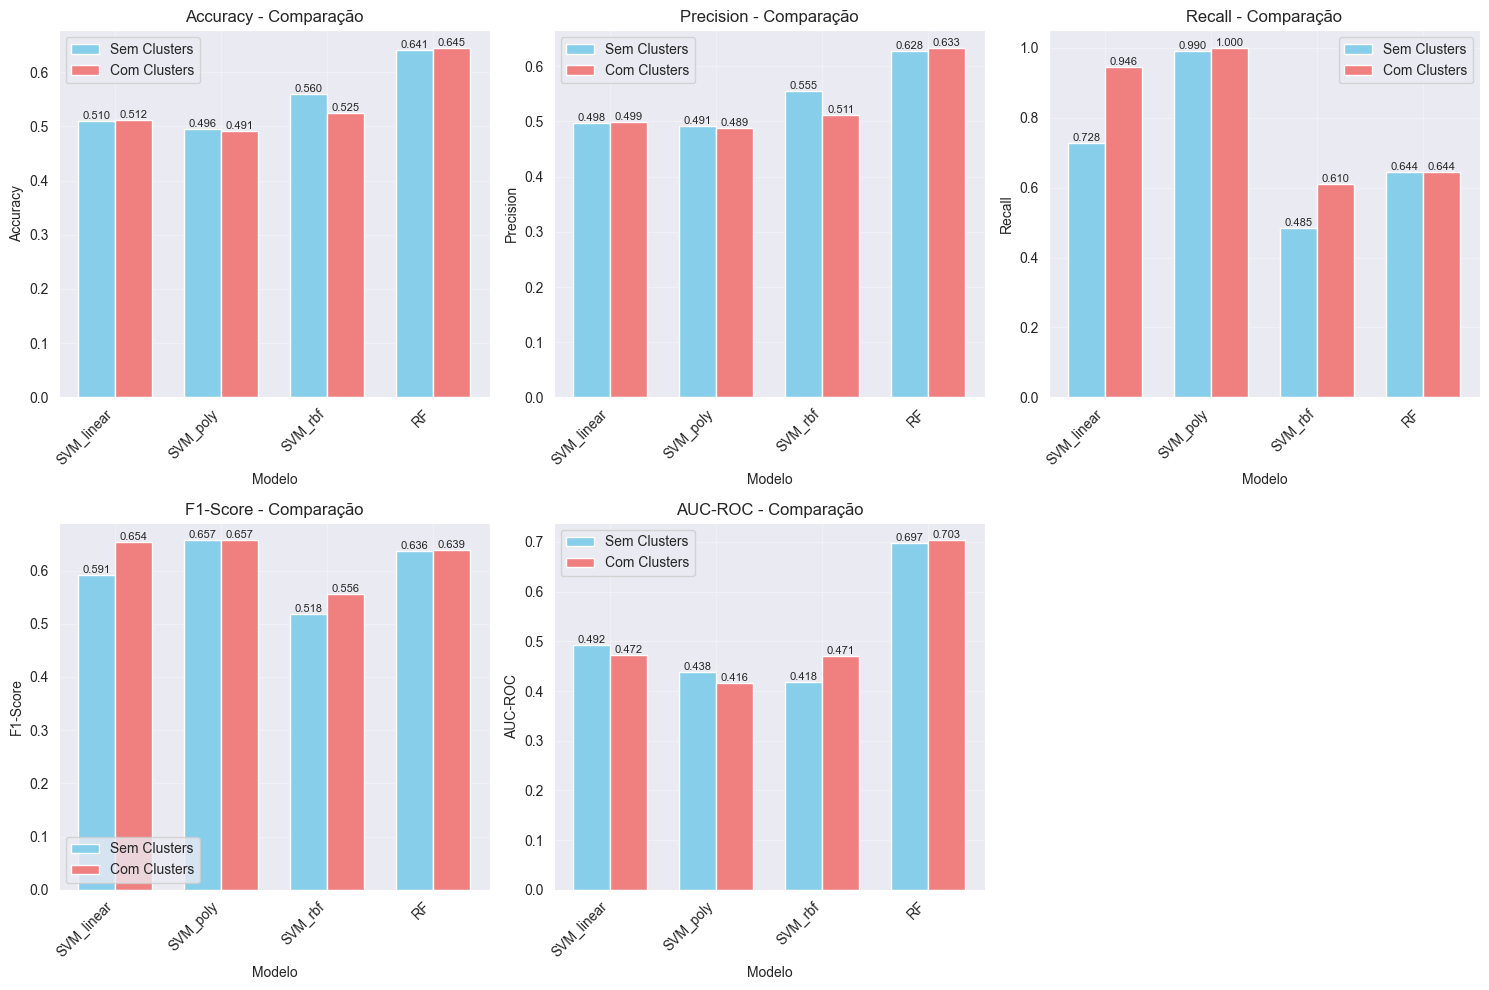

In [26]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

models_sem_cluster = [k for k in results.keys() if 'sem_cluster' in k]
models_com_cluster = [k for k in results.keys() if 'com_cluster' in k]

metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']

for idx, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
    ax = axes[idx // 3, idx % 3]
    
    sem_cluster_values = [results[m][metric] for m in models_sem_cluster]
    com_cluster_values = [results[m][metric] for m in models_com_cluster]
    
    x = np.arange(len(models_sem_cluster))
    width = 0.35
    
    labels = [m.replace('_sem_cluster', '') for m in models_sem_cluster]
    
    bars1 = ax.bar(x - width/2, sem_cluster_values, width, label='Sem Clusters', color='skyblue')
    bars2 = ax.bar(x + width/2, com_cluster_values, width, label='Com Clusters', color='lightcoral')
    
    ax.set_xlabel('Modelo')
    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name} - Comparação')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    for bar in bars1 + bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()

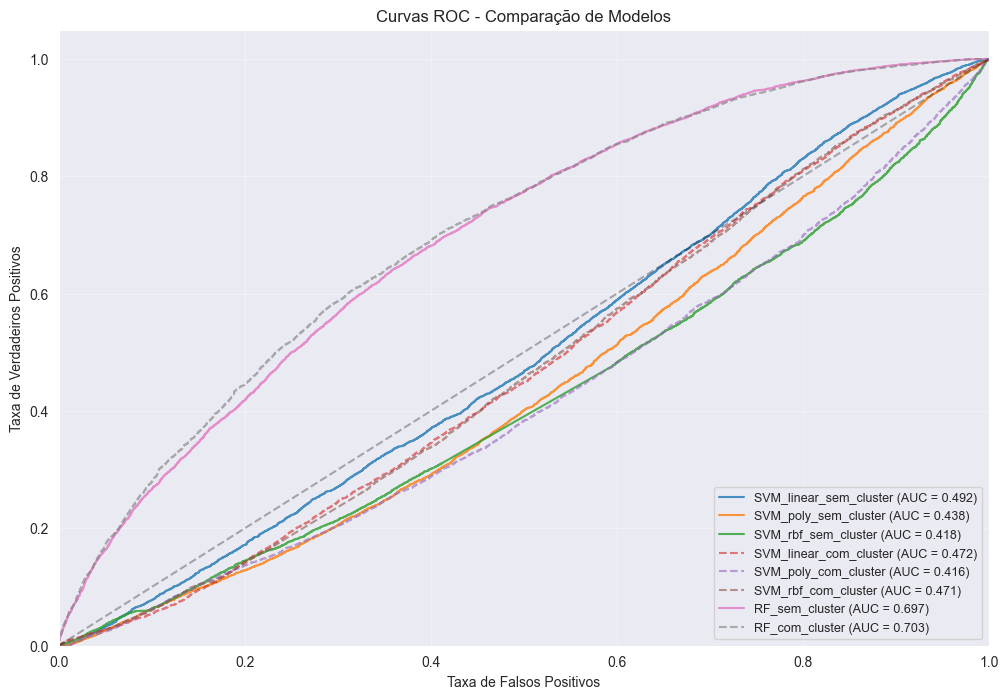

In [27]:
plt.figure(figsize=(12, 8))

for model_name, model_results in results.items():
    fpr, tpr, _ = roc_curve(y_test, model_results['y_proba'])
    auc = model_results['auc']
    
    if 'sem_cluster' in model_name:
        linestyle = '-'
        alpha = 0.8
    else:
        linestyle = '--'
        alpha = 0.6
    
    plt.plot(fpr, tpr, linestyle=linestyle, alpha=alpha, 
             label=f'{model_name} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curvas ROC - Comparação de Modelos')
plt.legend(loc="lower right", fontsize=9)
plt.grid(True, alpha=0.3)
plt.show()

In [28]:
impact_analysis = []

for base_model in ['SVM_linear', 'SVM_poly', 'SVM_rbf', 'RF']:
    sem_cluster_key = f'{base_model}_sem_cluster'
    com_cluster_key = f'{base_model}_com_cluster'
    
    if sem_cluster_key in results and com_cluster_key in results:
        acc_sem = results[sem_cluster_key]['accuracy']
        acc_com = results[com_cluster_key]['accuracy']
        f1_sem = results[sem_cluster_key]['f1']
        f1_com = results[com_cluster_key]['f1']
        
        impact_analysis.append({
            'Modelo': base_model,
            'Accuracy Sem Cluster': acc_sem,
            'Accuracy Com Cluster': acc_com,
            'Melhoria Accuracy (%)': ((acc_com - acc_sem) / acc_sem) * 100,
            'F1 Sem Cluster': f1_sem,
            'F1 Com Cluster': f1_com,
            'Melhoria F1 (%)': ((f1_com - f1_sem) / f1_sem) * 100
        })

impact_df = pd.DataFrame(impact_analysis)
print("\nAnálise do Impacto das Features de Cluster:")
print(impact_df.to_string(index=False))


Análise do Impacto das Features de Cluster:
    Modelo  Accuracy Sem Cluster  Accuracy Com Cluster  Melhoria Accuracy (%)  F1 Sem Cluster  F1 Com Cluster  Melhoria F1 (%)
SVM_linear              0.509518              0.511623               0.413188        0.591100        0.653795        10.606409
  SVM_poly              0.495702              0.490702              -1.008671        0.656797        0.656734        -0.009522
   SVM_rbf              0.559868              0.525307              -6.173130        0.517896        0.556198         7.395741
        RF              0.640570              0.644825               0.664156        0.635956        0.638579         0.412481


### Influência do Número de Clusters

Testando influência do número de clusters (versão otimizada)...
  K=2: SVM=0.525, RF=0.641
  K=3: SVM=0.544, RF=0.645
  K=4: SVM=0.545, RF=0.640
  K=5: SVM=0.540, RF=0.644


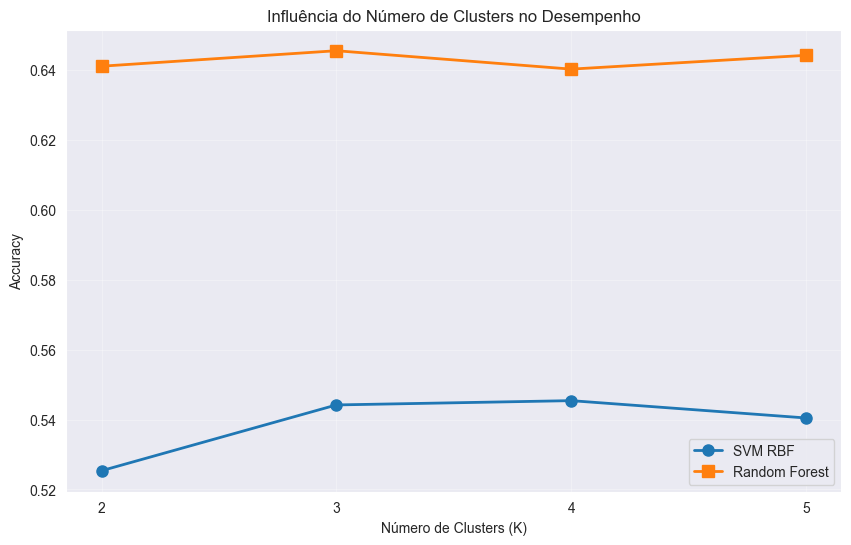


Melhor K para SVM: 4 (Accuracy: 0.545)
Melhor K para RF: 3 (Accuracy: 0.645)


In [29]:
k_values = [2, 3, 4, 5]
svm_accuracies = []
rf_accuracies = []

print("Testando influência do número de clusters (versão otimizada)...")
for k in k_values:
    kmeans_k = KMeans(n_clusters=k, random_state=42, n_init=5)
    kmeans_k.fit(X_train_sample)

    train_dist_k = calculate_cluster_distances(X_train_sample, kmeans_k)
    test_dist_k = calculate_cluster_distances(X_test_scaled, kmeans_k)
    
    X_train_k = np.hstack([X_train_sample, train_dist_k])
    X_test_k = np.hstack([X_test_scaled, test_dist_k])
    
    # SVM RBF
    svm_k = SVC(kernel='rbf', C=1, gamma='scale', random_state=42, max_iter=500)
    svm_k.fit(X_train_k, y_train_sample)
    svm_acc = accuracy_score(y_test, svm_k.predict(X_test_k))
    svm_accuracies.append(svm_acc)
    
    # Random Forest
    rf_k = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
    rf_k.fit(X_train_k, y_train_sample)
    rf_acc = accuracy_score(y_test, rf_k.predict(X_test_k))
    rf_accuracies.append(rf_acc)
    
    print(f"  K={k}: SVM={svm_acc:.3f}, RF={rf_acc:.3f}")

# influência de K
plt.figure(figsize=(10, 6))
plt.plot(k_values, svm_accuracies, 'o-', label='SVM RBF', linewidth=2, markersize=8)
plt.plot(k_values, rf_accuracies, 's-', label='Random Forest', linewidth=2, markersize=8)
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Accuracy')
plt.title('Influência do Número de Clusters no Desempenho')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(k_values)
plt.show()

print(f"\nMelhor K para SVM: {k_values[np.argmax(svm_accuracies)]} (Accuracy: {max(svm_accuracies):.3f})")
print(f"Melhor K para RF: {k_values[np.argmax(rf_accuracies)]} (Accuracy: {max(rf_accuracies):.3f})")

## 8. Diretrizes para Aplicação Efetiva

Com base nos resultados obtidos, as seguintes diretrizes são recomendadas para o uso de clusterização K-Médias como feature engineering:

In [31]:
diretrizes = """
DIRETRIZES PARA USO DE K-MÉDIAS COMO FEATURE ENGINEERING:

1. DETERMINAÇÃO DO NÚMERO DE CLUSTERS:
   - Utilizar métodos combinados (cotovelo + silhueta)
   - Testar múltiplos valores de K para encontrar o ótimo
   - K ótimo pode variar dependendo do modelo de classificação

2. CRIAÇÃO DE FEATURES:
   - Distâncias aos centroides são mais informativas que labels de cluster
   - Adicionar distâncias a TODOS os centroides, não apenas ao mais próximo
   - Normalizar features antes da clusterização

3. SELEÇÃO DE MODELOS:
   - SVM com kernel RBF tende a se beneficiar mais das features de cluster
   - Random Forest pode ter ganhos marginais ou até piora de desempenho
   - Modelos lineares (SVM linear) têm benefício limitado

4. VALIDAÇÃO:
   - Sempre comparar com baseline (sem features de cluster)
   - Usar cross-validation para evitar overfitting
   - Considerar o trade-off entre complexidade e ganho de performance

5. APLICABILIDADE:
   - Mais efetivo quando dados possuem estrutura de grupos naturais
   - Verificar se clusters têm significado semântico
   - Considerar custo computacional adicional
"""

print(diretrizes)

best_model_name = metrics_df.iloc[0]['Modelo']
best_accuracy = metrics_df.iloc[0]['Accuracy']
print(f"\n{'='*60}")
print(f"MELHOR MODELO: {best_model_name}")
print(f"ACCURACY: {best_accuracy:.4f}")
print(f"{'='*60}")


DIRETRIZES PARA USO DE K-MÉDIAS COMO FEATURE ENGINEERING:

1. DETERMINAÇÃO DO NÚMERO DE CLUSTERS:
   - Utilizar métodos combinados (cotovelo + silhueta)
   - Testar múltiplos valores de K para encontrar o ótimo
   - K ótimo pode variar dependendo do modelo de classificação

2. CRIAÇÃO DE FEATURES:
   - Distâncias aos centroides são mais informativas que labels de cluster
   - Adicionar distâncias a TODOS os centroides, não apenas ao mais próximo
   - Normalizar features antes da clusterização

3. SELEÇÃO DE MODELOS:
   - SVM com kernel RBF tende a se beneficiar mais das features de cluster
   - Random Forest pode ter ganhos marginais ou até piora de desempenho
   - Modelos lineares (SVM linear) têm benefício limitado

4. VALIDAÇÃO:
   - Sempre comparar com baseline (sem features de cluster)
   - Usar cross-validation para evitar overfitting
   - Considerar o trade-off entre complexidade e ganho de performance

5. APLICABILIDADE:
   - Mais efetivo quando dados possuem estrutura de grup